In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import bambi as bmb
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import log
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

In [2]:
def crear_variables_derivadas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crea nuevas variables derivadas a partir del DataFrame df_merge:
    - tasa_activacion = cuentas_pago / cuentas_validadas_totales
    - operaciones_por_cuenta_activa = operaciones / cuentas_pago
    - monto_promedio_por_operacion = monto / operaciones
    Aplica por banco (bbva, bancoppel, etc.) y también algunas variables globales.
    """
    df = df.copy()

    # Tasa de activación total
    df["tasa_activacion_total"] = df["cuentas_pago"] / (df["cuentas_bbva"] + df["cuentas_bancoppel"] + df["cuentas_azteca"] + df["cuentas_otros"] + df["cuentas_stp"])

    # Por banco
    bancos = ["bbva", "bancoppel", "azteca", "otros", "stp"]
    for banco in bancos:
        # Operaciones por cuenta activa
        df[f"ops_por_cuenta_{banco}"] = df[f"operaciones_{banco}"] / df[f"cuentas_{banco}"]

        # Monto promedio por operación
        df[f"monto_por_operacion_{banco}"] = df[f"monto_{banco}"] / df[f"operaciones_{banco}"]

    # Dispositivos totales
    df["dispositivos_totales"] = df["dispositivos_android"] + df["dispositivos_ios"]
    df["proporcion_android"] = df["dispositivos_android"] / df["dispositivos_totales"]

    return df


def agregar_deltas_y_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrega al DataFrame:
    - Deltas proporcionales (pct_change) para variables no target
    - Ratios de dispositivos por cuenta
    - Proporción de cuentas de pago vs cobro
    """
    df = df.copy()
    
    # Cambios proporcionales (evitamos target como montos y operaciones)
    columnas_deltas = ["cuentas_pago", "cuentas_cobro", "dispositivos_android", "dispositivos_ios"]
    # ["cuentas_bbva", "cuentas_bancoppel", "cuentas_azteca", "cuentas_otros", "cuentas_stp"]

    for col in columnas_deltas:
        if col in df.columns:
            df[f"delta_{col}"] = df[col].pct_change()

    # Total de dispositivos y cuentas
    df["dispositivos_totales"] = df["dispositivos_android"] + df["dispositivos_ios"]
    df["cuentas_total"] = df[["cuentas_bbva", "cuentas_bancoppel", "cuentas_azteca", "cuentas_otros", "cuentas_stp"]].sum(axis=1)

    # Ratio dispositivos por cuenta activa
    # df["dispositivos_por_cuenta_pago"] = df["dispositivos_totales"] / df["cuentas_pago"]
    # df["dispositivos_por_cuenta_total"] = df["dispositivos_totales"] / df["cuentas_total"]

    # Proporción cuentas de pago respecto al total de cuentas activas
    # df["cuentas_pago_vs_total"] = df["cuentas_pago"] / (df["cuentas_pago"] + df["cuentas_cobro"])

    return df

def seleccionar_features(df: pd.DataFrame, targets: list) -> list:
    """
    Dada una lista de variables objetivo (targets), devuelve una lista de columnas recomendadas como features:
    - Excluye columnas que sean los targets explícitos
    - Excluye columnas derivadas del target (por ejemplo, 'monto_por_operacion_*' si 'monto' está en target)
    - Excluye columnas que contienen 'total' o 'totales' (excepto 'tasa_activacion_total')
    - Retorna solo columnas numéricas que no estén directamente relacionadas con los targets
    """
    columnas = df.columns
    features = []

    for col in columnas:
        # Excluir si es un target directo
        if any(target in col for target in targets):
            continue
        # Excluir si es una derivación típica del target
        if any("por_operacion" in col or "por_cuenta" in col for target in targets):
            continue
        # Excluir si contiene "total" o "totales", excepto tasa_activacion_total
        if ("total" in col.lower() or "totales" in col.lower()) and col != "tasa_activacion_total":
            continue
        # Incluir solo columnas numéricas válidas
        if col != "fecha" and pd.api.types.is_numeric_dtype(df[col]):
            features.append(col)

    return features

def aplicar_min_max_scaling(df: pd.DataFrame, columnas: list) -> pd.DataFrame:
    """
    Aplica Min-Max Scaling a las columnas seleccionadas del DataFrame.
    Devuelve el DataFrame con las columnas escaladas (entre 0 y 1).
    """
    df = df.copy()
    scaler = MinMaxScaler()
    columnas_min_max = [col+"_scaling" for col in columnas]
    df[columnas_min_max] = scaler.fit_transform(df[columnas])
    return df

def ajustar_glm_gamma_por_banco(df: pd.DataFrame, bancos: list, target_base: str = "monto") -> dict:
    """
    Ajusta un GLM (Gamma con enlace log) para cada banco en la lista.
    Usa automáticamente las features seleccionadas sin leakage.

    Retorna:
    - Diccionario con resultados del modelo por banco.
    """
    resultados_modelos = {}

    for banco in bancos:
        target_col = f"{target_base}_{banco}"
        if target_col not in df.columns:
            continue

        # Seleccionar features excluyendo todas las relacionadas al target
        features = seleccionar_features(df, targets=[target_base])
        df_model = df[["fecha", target_col] + features].dropna()

        # Definir X y y
        X = df_model[features]
        X = sm.add_constant(X)
        y = df_model[target_col]

        # Ajustar modelo
        modelo = GLM(y, X, family=Gamma(link=log()))
        resultado = modelo.fit()

        resultados_modelos[banco] = resultado

    return resultados_modelos

def interpretar_coeficientes_glm(resultados_modelo, banco: str) -> pd.DataFrame:
    """
    Recibe el resultado de un modelo GLM (statsmodels) y devuelve una tabla interpretativa:
    - Coeficiente
    - Error estándar
    - p-valor
    - Exp(coef): efecto multiplicativo
    - Efecto % aproximado
    - Significancia (* si p < 0.05)
    """
    res = resultados_modelo[banco]
    coef = res.params
    std_err = res.bse
    pval = res.pvalues

    interpretacion = pd.DataFrame({
        "Coeficiente": coef,
        "Error estándar": std_err,
        "p-valor": pval,
        "Exp(Coef)": np.exp(coef),
        "Efecto % aprox.": (np.exp(coef) - 1) * 100,
        "Significativo": pval < 0.05
    })

    interpretacion["Signo"] = interpretacion["Coeficiente"].apply(lambda x: "+" if x > 0 else "-")
    interpretacion["Interpretación"] = interpretacion.apply(
        lambda row: (
            f"Aumenta Y en aproximadamente {row['Efecto % aprox.']:.1f}% por unidad extra de X"
            if row["Coeficiente"] > 0
            else f"Disminuye Y en aproximadamente {abs(row['Efecto % aprox.']):.1f}% por unidad extra de X"
        ), axis=1
    )

    return interpretacion.sort_values(by="Efecto % aprox.", ascending=False)


def flujo_validacion_temporal_glm_con_entrenamiento(df: pd.DataFrame, bancos: list, target_base: str = "monto", fecha_corte: str = "2024-12-31"):
    """
    Igual que flujo_validacion_temporal_glm, pero además:
    - Incluye gráfico extendido con entrenamiento + validación
    """
    fecha_corte = pd.to_datetime(fecha_corte)
    df_train = df[df["fecha"] <= fecha_corte].copy()
    df_test = df[df["fecha"] > fecha_corte].copy()

    resultados_modelos = ajustar_glm_gamma_por_banco(df_train, bancos, target_base)
    metricas = {}

    for banco in bancos:
        target_col = f"{target_base}_{banco}"
        if target_col not in df.columns:
            continue

        # Seleccionar features válidas
        features = seleccionar_features(df, targets=[target_base])

        # Entrenamiento
        df_train_clean = df_train[["fecha", target_col] + features].dropna()
        X_train = sm.add_constant(df_train_clean[features])
        y_train = df_train_clean[target_col]

        # Test
        df_test_clean = df_test[["fecha", target_col] + features].dropna()
        if df_test_clean.empty:
            continue
        X_test = sm.add_constant(df_test_clean[features])
        y_test = df_test_clean[target_col]

        modelo = resultados_modelos.get(banco)
        if modelo is None:
            continue

        y_pred_train = modelo.predict(X_train)
        y_pred_test = modelo.predict(X_test)

        # Métricas de validación
        mae = mean_absolute_error(y_test, y_pred_test)
        mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
        metricas[banco] = {"MAE": mae, "MAPE": mape}

        # Gráfico comparativo extendido
        plt.figure(figsize=(10, 5))
        plt.plot(df_train_clean["fecha"], y_train, label="Real (entrenamiento)", linestyle="solid")
        plt.plot(df_train_clean["fecha"], y_pred_train, label="Predicho (entrenamiento)", linestyle="dashed")
        plt.plot(df_test_clean["fecha"], y_test, label="Real (validación)", linestyle="solid", color="black", marker="o")
        plt.plot(df_test_clean["fecha"], y_pred_test, label="Predicho (validación)", linestyle="dashed", color="red", marker="x")
        plt.axvline(fecha_corte, color="gray", linestyle="--", label="Corte entrenamiento")
        plt.title(f"Entrenamiento + Validación - {banco.upper()}")
        plt.xlabel("Fecha")
        plt.ylabel("Monto")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return resultados_modelos, metricas

def preparar_dataframe_jerarquico(df: pd.DataFrame, bancos: list) -> pd.DataFrame:
    """
    Prepara un DataFrame largo (tidy) para modelado jerárquico.
    Estructura final: una fila por banco y fecha.
    Variables: monto, cuentas, operaciones, dispositivos.

    Retorna:
    - DataFrame con columnas: fecha, banco, monto, cuentas, operaciones, dispositivos_android, dispositivos_ios
    """
    registros = []

    for banco in bancos:
        if all(f in df.columns for f in [f"monto_{banco}", f"cuentas_{banco}", f"operaciones_{banco}"]):
            temp_df = pd.DataFrame({
                "fecha": df["fecha"],
                "banco": banco,
                "monto": df[f"monto_{banco}"],
                "cuentas": df[f"cuentas_{banco}"],
                "operaciones": df[f"operaciones_{banco}"],
                "dispositivos_android": df["dispositivos_android"],
                "dispositivos_ios": df["dispositivos_ios"]
            })
            registros.append(temp_df)

    df_largo = pd.concat(registros, ignore_index=True)
    return df_largo.dropna()  # quitar cualquier fila incompleta antes de modelar



In [3]:
df = pd.read_csv("./data/clean_data.csv")
df['fecha'] = pd.to_datetime(df['fecha'])

In [5]:
df.columns

Index(['fecha', 'dispositivos_android', 'dispositivos_ios', 'cuentas_pago',
       'cuentas_cobro', 'diferencia_pago_cobro', 'cuentas_bbva',
       'cuentas_bancoppel', 'cuentas_azteca', 'cuentas_otros', 'cuentas_stp',
       'monto_bbva', 'monto_bancoppel', 'monto_azteca', 'monto_otros',
       'monto_stp', 'operaciones_bbva', 'operaciones_bancoppel',
       'operaciones_azteca', 'operaciones_otros', 'operaciones_stp'],
      dtype='object')

In [14]:
vars_cuentas_banco = ['cuentas_bbva', 'cuentas_bancoppel', 'cuentas_azteca', 'cuentas_otros', 'cuentas_stp']
vars_operaciones_banco = ['operaciones_bbva', 'operaciones_bancoppel', 'operaciones_azteca', 'operaciones_otros', 'operaciones_stp']
vars_montos_banco = ['monto_bbva', 'monto_bancoppel', 'monto_azteca', 'monto_otros', 'monto_stp']

In [25]:
df = crear_variables_derivadas(df)
df = agregar_deltas_y_ratios(df)
df = aplicar_min_max_scaling(df,columnas=vars_cuentas_banco+vars_operaciones_banco+vars_montos_banco)

In [167]:
#df.to_csv("./data/data_codi.csv",index=False)

In [35]:
# Para un modelo que prediga montos por banco:
features_monto = seleccionar_features(df, targets=["monto"])
# Para operaciones:
features_operaciones = seleccionar_features(df, targets=["operaciones"])
# Para cuentas:
features_cuentas = seleccionar_features(df, targets=["cuentas"])

In [20]:
features_cuentas

['dispositivos_android',
 'dispositivos_ios',
 'diferencia_pago_cobro',
 'monto_bbva',
 'monto_bancoppel',
 'monto_azteca',
 'monto_otros',
 'monto_stp',
 'operaciones_bbva',
 'operaciones_bancoppel',
 'operaciones_azteca',
 'operaciones_otros',
 'operaciones_stp',
 'tasa_activacion_total',
 'proporcion_android',
 'delta_dispositivos_android',
 'delta_dispositivos_ios']

In [36]:
vars_model = ['proporcion_android', 'delta_cuentas_pago',
 'delta_cuentas_cobro',
 'delta_dispositivos_android',
 'delta_dispositivos_ios',
 'cuentas_bbva_scaling',
 'cuentas_bancoppel_scaling',
 'cuentas_azteca_scaling',
 'cuentas_otros_scaling',
 'cuentas_stp_scaling',
 'operaciones_bbva_scaling',
 'operaciones_bancoppel_scaling',
 'operaciones_azteca_scaling',
 'operaciones_otros_scaling',
 'operaciones_stp_scaling']
targets = ['monto_bbva', 'monto_bancoppel', 'monto_azteca', 'monto_otros', 'monto_stp']

In [72]:
    # plt.figure(figsize=(12, 10))
    # corr = df[vars].corr()
    # sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
    # plt.title("Matriz de correlación")
    # plt.show()

In [38]:
data_model = df[["fecha"]+vars_model+targets].copy()

KeyError: "['proporcion_android', 'delta_cuentas_pago', 'delta_cuentas_cobro', 'delta_dispositivos_android', 'delta_dispositivos_ios', 'cuentas_bbva_scaling', 'cuentas_bancoppel_scaling', 'cuentas_azteca_scaling', 'cuentas_otros_scaling', 'cuentas_stp_scaling', 'operaciones_bbva_scaling', 'operaciones_bancoppel_scaling', 'operaciones_azteca_scaling', 'operaciones_otros_scaling', 'operaciones_stp_scaling'] not in index"

/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead

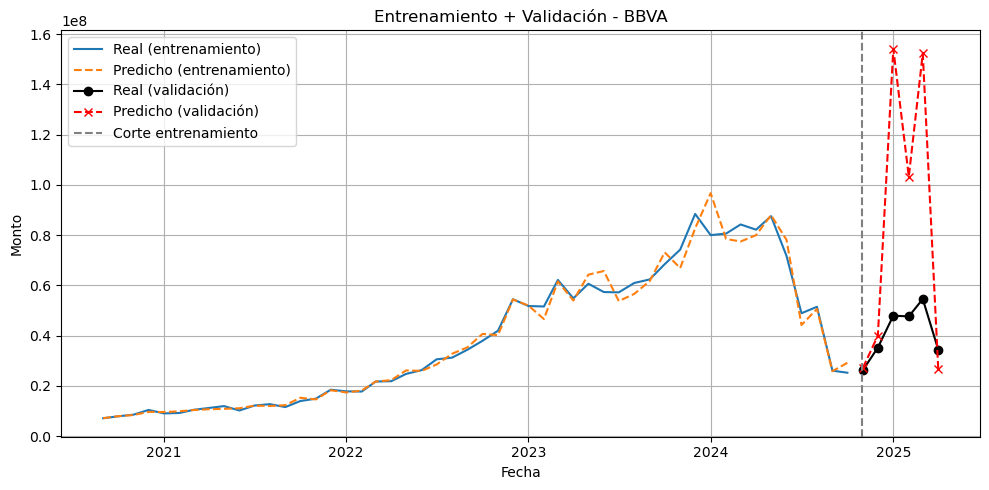

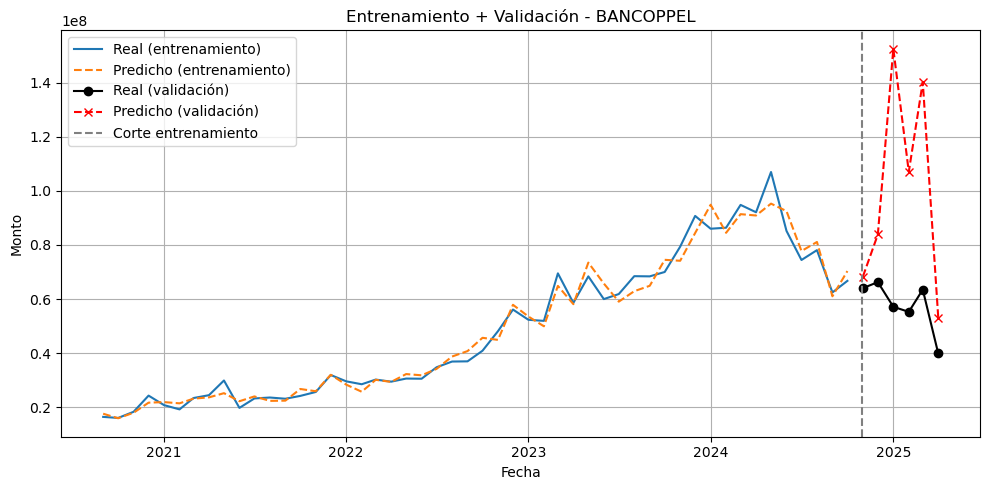

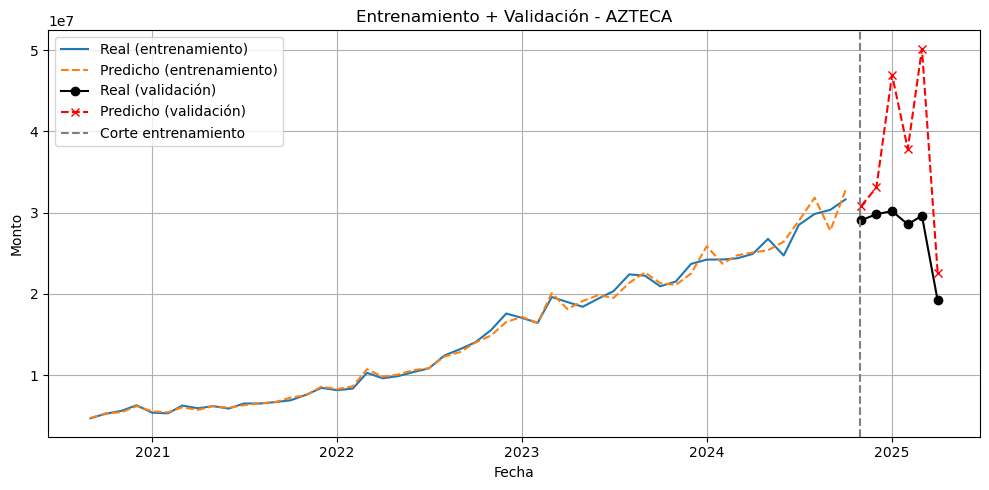

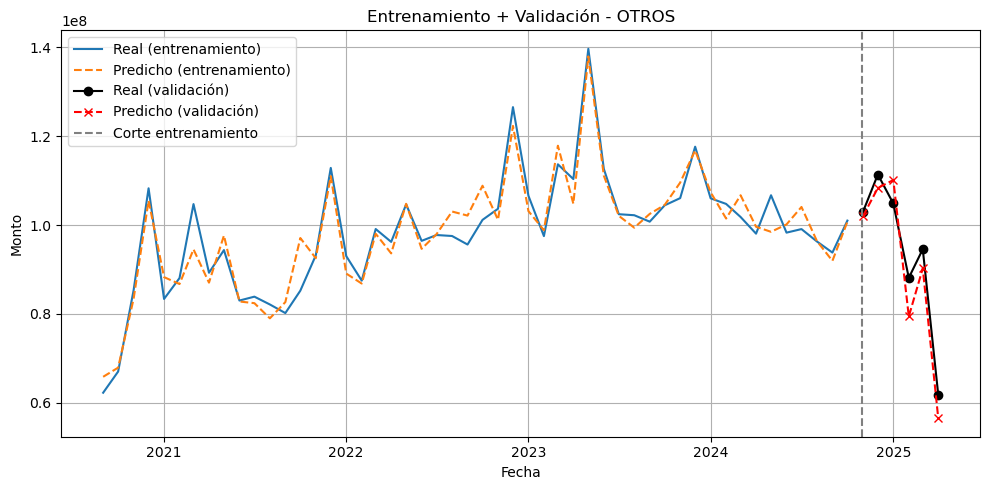

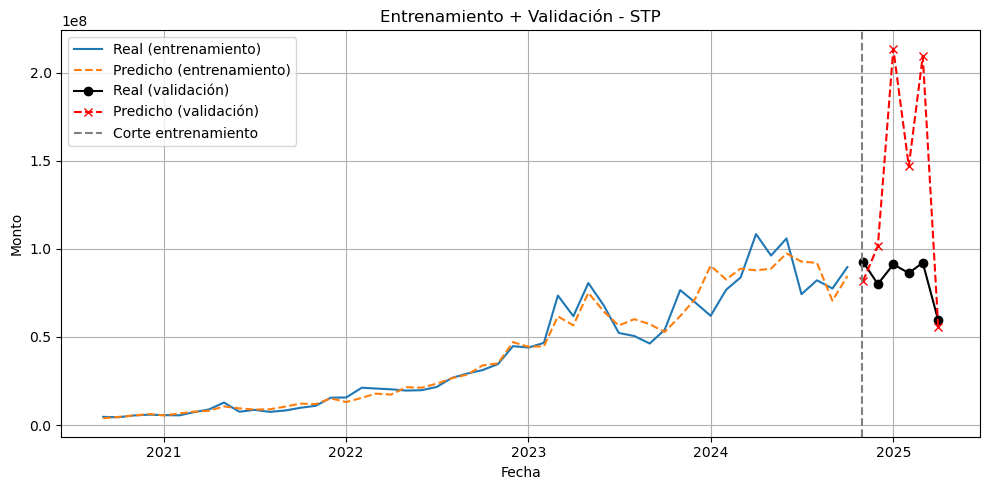

In [34]:
resultados_modelos, metricas = flujo_validacion_temporal_glm_con_entrenamiento(
    df=data_model,
    bancos=["bbva", "bancoppel", "azteca", "otros", "stp"],
    target_base="monto",
    fecha_corte="2024-10-30"
)


In [114]:
interpretar_coeficientes_glm(resultados_modelos, "bbva")

,Coeficiente,Error estándar,p-valor,Exp(Coef),Efecto % aprox.,Significativo,Signo,Interpretación
const,27.727066,6.544532,0.000023,1.100809e+12,1.100809e+14,True,+,Aumenta Y en aproximadamente 110080889273197.9...
delta_cuentas_pago,6.730703,5.409159,0.213383,8.377358e+02,8.367358e+04,False,+,Aumenta Y en aproximadamente 83673.6% por unid...
delta_dispositivos_android,3.113925,3.194168,0.329621,2.250923e+01,2.150923e+03,False,+,Aumenta Y en aproximadamente 2150.9% por unida...
operaciones_otros_scaling,0.996130,0.319732,0.001836,2.707782e+00,1.707782e+02,True,+,Aumenta Y en aproximadamente 170.8% por unidad...
operaciones_bbva_scaling,0.902661,0.424458,0.033452,2.466157e+00,1.466157e+02,True,+,Aumenta Y en aproximadamente 146.6% por unidad...
operaciones_stp_scaling,0.764436,0.557430,0.170263,2.147783e+00,1.147783e+02,False,+,Aumenta Y en aproximadamente 114.8% por unidad...
cuentas_bbva_scaling,0.168664,0.185567,0.363397,1.183723e+00,1.837228e+01,False,+,Aumenta Y en aproximadamente 18.4% por unidad ...
operaciones_bancoppel_scaling,0.017275,0.539328,0.974447,1.017425e+00,1.742546e+00,False,+,Aumenta Y en aproximadamente 1.7% por unidad e...
cuentas_stp_scaling,-0.077478,0.130870,0.553833,9.254472e-01,-7.455280e+00,False,-,Disminuye Y en aproximadamente 7.5% por unidad...
cuentas_azteca_scaling,-0.107367,0.117411,0.360481,8.981961e-01,-1.018039e+01,False,-,Disminuye Y en aproximadamente 10.2% por unida...


In [28]:
resultados_modelos["bbva"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             monto_bbva   No. Observations:                   49
Model:                            GLM   Df Residuals:                       33
Model Family:                   Gamma   Df Model:                           15
Link Function:                    log   Scale:                       0.0094979
Method:                          IRLS   Log-Likelihood:                -791.21
Date:                Tue, 06 May 2025   Deviance:                      0.31790
Time:                        19:18:04   Pearson chi2:                    0.313
No. Iterations:                    11   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            24.5889      6.461      3.806      0.000      11.925      37.253
proporcion_android              -11.1577      8.610     -1.296      0.195     -28.033       5.718
delta_cuentas_pago                7.9857      5.726      1.395      0.163      -3.237      19.209
delta_cuentas_cobro             -13.7775      5.046     -2.730      0.006     -23.667      -3.888
delta_dispositivos_android        4.3216      3.257      1.327      0.185      -2.063      10.706
delta_dispositivos_ios           -0.7520      1.483     -0.507      0.612      -3.658       2.154
cuentas_bbva_scaling              0.2164      0.193      1.119      0.263      -0.162       0.595
cuentas_bancoppel_scaling        -0.1392      0.241     -0.578      0.563      -0.611       0.333
cuentas_azteca_scaling           -0.1009      0.123     -0.818      0.414      -0.343       0.141
cuentas_otros_scaling            -0.3471      0.288     -1.205      0.228      -0.912       0.218
cuentas_stp_scaling              -0.0938      0.139     -0.673      0.501      -0.367       0.179
operaciones_bbva_scaling          1.5886      0.342      4.639      0.000       0.917       2.260
operaciones_bancoppel_scaling    -0.3746      0.550     -0.681      0.496      -1.452       0.703
operaciones_azteca_scaling       -0.7772      0.443     -1.756      0.079      -1.645       0.090
operaciones_otros_scaling         0.9273      0.333      2.786      0.005       0.275       1.580
operaciones_stp_scaling           0.7267      0.562      1.293      0.196      -0.374       1.828
=================================================================================================
"""

## Modelo Jerárquico

In [168]:
bancos = ["bbva", "bancoppel", "azteca", "otros", "stp"]
df_largo = preparar_dataframe_jerarquico(df, bancos)

In [170]:
df_largo.to_csv("data_codi_apilada.csv",index=False)

In [142]:
def escalar_predictores_log(df: pd.DataFrame, columnas: list) -> pd.DataFrame:
    df = df.copy()
    for col in columnas:
        # Para evitar log(0) o valores negativos, sumamos 1
        df[f"log_{col}"] = np.log(df[col] + 1)
    return df

def ajustar_modelo_jerarquico(df_largo: pd.DataFrame):
    """
    Ajusta un modelo jerárquico bayesiano con distribución Gamma:
    monto ~ cuentas + operaciones + dispositivos_android + dispositivos_ios + (1 | banco)
    """
    # Modelo con intercepto aleatorio por banco
    modelo = bmb.Model(
        "monto ~ log_cuentas + log_operaciones + log_dispositivos_android + log_dispositivos_ios + (1 | banco)",
        df_largo_log,
        family="gamma"
    )
    # Ajustar el modelo con muestreo MCMC
    resultado = modelo.fit(draws=1000, chains=2, progressbar=False)

    return modelo, resultado


In [ ]:
df_largo_log = escalar_predictores_log(df_largo, columnas = ['monto', 'cuentas', 'operaciones','dispositivos_android', 'dispositivos_ios'])
df_largo_log["log_cuentas"] = np.log(df_largo_log["cuentas"].clip(lower=0) + 1)


In [143]:
modelo = bmb.Model(
    "log_monto ~ log_cuentas + log_operaciones + log_dispositivos_android + log_dispositivos_ios + (1 | banco)",
    df_largo_log.dropna(),
    family="gaussian"
)
resultado = modelo.fit(draws=1000, chains=2, init="adapt_diag", tune=1000)



Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, log_cuentas, log_operaciones, log_dispositivos_android, log_dispositivos_ios, 1|banco_sigma, 1|banco_offset]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [158]:
resultado

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data